In [ ]:
#default_exp transform

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.notebook.showdoc import show_doc

In [ ]:
from PIL import Image

# Transforms

> Definition of `Transform` and `Pipeline`

The classes here provide functionality for creating a composition of *partially reversible functions*. By "partially reversible" we mean that a transform can be `decode`d, creating a form suitable for display. This is not necessarily identical to the original form (e.g. a transform that changes a byte tensor to a float tensor does not recreate a byte tensor when decoded, since that may lose precision, and a float tensor can be displayed already).

Classes are also provided and for composing transforms, and mapping them over collections. `Pipeline` is a transform which composes several `Transform`, knowing how to decode them or show an encoded item.

## Types

`TensorImage`, `TensorImageBW` and `TensorMask` are subclasses of `torch.Tensor` that know how to show themselves.

In [ ]:
#export
@delegates(plt.subplots, keep=True)
def subplots(nrows=1, ncols=1, **kwargs):
    fig,ax = plt.subplots(nrows,ncols,**kwargs)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
#export
class TensorImageBase(TensorBase):
    _show_args = {'cmap':'viridis'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})
    
    def show_multi(self, b, max_n=10, ctxs=None, rows=None, cols=None, figsize=None, **kwargs):
        if ctxs is None:
            n_samples = min(len(b), max_n)
            rows = rows or int(np.ceil(math.sqrt(n_samples)))
            cols = cols or int(np.ceil(n_samples/rows))
            figsize = (cols*3, rows*3) if figsize is None else figsize
            _,ctxs = subplots(rows, cols, figsize=figsize)
            ctxs = ctxs.flatten()
            for ctx in ctxs[max_n:]: ctx.set_axis_off()
        ctxs = [b_.show(ctx=c, **kwargs) for b_,c,_ in zip(b,ctxs,range(max_n))]
        return ctxs

In [ ]:
#export
class TensorImage(TensorImageBase): pass

In [ ]:
#export
class TensorImageBW(TensorImage): _show_args = {'cmap':'Greys'}

In [ ]:
#export
class TensorMask(TensorImageBase): _show_args = {'alpha':0.5, 'cmap':'tab20'}

In [ ]:
im = Image.open(TEST_IMAGE)

In [ ]:
im_t = TensorImage(array(im))
test_eq(type(im_t), TensorImage)

In [ ]:
im_t2 = TensorMask(tensor(1))
test_eq(type(im_t2), TensorMask)
test_eq(im_t2, tensor(1))

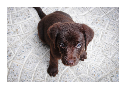

In [ ]:
ax = im_t.show(figsize=(2,2))

In [ ]:
test_fig_exists(ax)

AttributeError: 'list' object has no attribute 'shape'

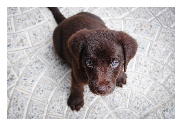

In [ ]:
#hide
axes = im_t.show_multi([im_t])
test_eq(axes.shape,[1])
plt.close()
axes = im_t.show_multi([im_t, im_t, im_t, im_t])
test_eq(axes.shape,[4])
plt.close()

## Transform -

In [ ]:
#export
_tfm_methods = 'encodes','decodes','setups'

class _TfmDict(dict):
    def __setitem__(self,k,v):
        if k not in _tfm_methods or not callable(v): return super().__setitem__(k,v)
        if k not in self: super().__setitem__(k,TypeDispatch())
        self[k].add(v)

In [ ]:
#export
class _TfmMeta(type):
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        res.__signature__ = inspect.signature(res.__init__)
        return res

    def __call__(cls, *args, **kwargs):
        f = args[0] if args else None
        n = getattr(f,'__name__',None)
        for nm in _tfm_methods:
            if not hasattr(cls,nm): setattr(cls, nm, TypeDispatch())
        if callable(f) and n in _tfm_methods:
            getattr(cls,n).add(f)
            return f
        return super().__call__(*args, **kwargs)

    @classmethod
    def __prepare__(cls, name, bases): return _TfmDict()

In [ ]:
#export
class Transform(metaclass=_TfmMeta):
    "Delegates (`__call__`,`decode`,`setup`) to (`encodes`,`decodes`,`setups`) if `split_idx` matches"
    split_idx,init_enc,as_item_force,as_item,order = None,False,None,True,0
    def __init__(self, enc=None, dec=None, split_idx=None, as_item=False):
        self.split_idx,self.as_item = ifnone(split_idx, self.split_idx),as_item
        self.init_enc = enc or dec
        if not self.init_enc: return

        # Passing enc/dec, so need to remove (base) class level enc/dec
        del(self.__class__.encodes,self.__class__.decodes,self.__class__.setups)
        self.encodes,self.decodes,self.setups = TypeDispatch(),TypeDispatch(),TypeDispatch()
        if enc:
            self.encodes.add(enc)
            self.order = getattr(self.encodes,'order',self.order)
        if dec: self.decodes.add(dec)

    @property
    def use_as_item(self): return ifnone(self.as_item_force, self.as_item)
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
    def decode  (self, x, **kwargs): return self._call('decodes', x, **kwargs)
    def setup(self, items=None): return self.setups(items)
    def __repr__(self): return f'{self.__class__.__name__}: {self.use_as_item} {self.encodes} {self.decodes}'

    def _call(self, fn, x, split_idx=None, **kwargs):
        if split_idx!=self.split_idx and self.split_idx is not None: return x
        f = getattr(self, fn)
        if self.use_as_item or not is_listy(x): return self._do_call(f, x, **kwargs)
        res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
        return retain_type(res, x)

    def _do_call(self, f, x, **kwargs):
        return x if f is None else retain_type(f(x, **kwargs), x, f.returns_none(x))

add_docs(Transform, decode="Delegate to `decodes` to undo transform", setup="Delegate to `setups` to set up transform")

In [ ]:
show_doc(Transform)

A `Transform` is the main building block of the fastai data pipelines. In the most general terms a transform can be any function you want to apply to your data, however the `Transform` class provides several mechanisms that make the process of building them easy and flexible.

### The main `Transform` features:

- **Type dispatch** - Type annotations are used to determine if a transform should be applied to the given argument. It also gives an option to provide several implementations and it choses the one to run based on the type. This is useful for example when running both independent and dependent variables through the pipeline where some transforms only make sense for one and not the other. Another usecase is designing a transform that handles different data formats. Note that if a transform takes multiple arguments only the type of the first one is used for dispatch. 
- **Handling of tuples** - When a tuple (or another collection satisfying `is_listy`) of data is passed to a transform it will get applied to each element separately. Most comonly it will be a *(x,y)* tuple, but it can be anything for example a list of images. You can opt out of this behavior by setting the flag `as_item=True`. For transforms that must always operate on the tuple level you can set `as_item_force=True` which takes precedence over `as_item`, an example of that is `PointScaler`.
- **Reversability** - A transform can be made reversible by implementing the `decodes` method. This is mainly used to turn something like a category which is encoded as a number back into a label understandable by humans for showing purposes.
- **Type propagation** - Whenever possible a transform tries to return data of the same type it received. Mainly used to maintain semantics of things like `TensorImage` which is a thin wrapper of pytorches `Tensor`. You can opt out of this behavior by adding `->None` return type annotation.
- **Preprocessing** - The `setup` method can be used to perform any one-time calculations to be later used by the transform, for example generating a vocabulary to encode categorical data.
- **Filtering based on the dataset type** - By setting the `split_idx` flag you can make the transform be used only in a specific `DataSource` subset like in training, but not validation.
- **Ordering** - You can set the `order` attribute which the `Pipeline` uses when it needs to merge two lists of transforms.
- **Appending new behavior with decorators** - You can easily extend an existing `Transform` by creating `encodes` or `decodes` methods for new data types. You can put those new methods outside the original transform definition and decorate them with the class you wish them patched into. This can be used by the fastai library users to add their own behavior, or multiple modules contributing to the same transform.

### Defining a `Transform`
There are a few ways to create a transform with different ratios of simplicity to flexibility.
- **Extending the `Transform` class** - Use inheritence to implement the methods you want.
- **Passing methods to the constructor** - Instantiate the `Transform` class and pass your functions as `enc` and `dec` arguments.
- **@Transform decorator** - Turn any function into a `Transform` by just adding a decorator - very straightforward if all you need is a single `encodes` implementation.
- **Passing a function to fastai APIs** - Same as above, but when passing a function to other transform aware classes like `Pipeline` or `TfmdDS` you don't even need a decorator. Your function will get converted to a `Transform` automatically.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x): return x+1
f1 = A()
test_eq(f1(1), 2)

class B(A): pass
f2 = B()
test_eq(f2(1), 2)

class A(Transform): pass
f3 = A()
test_eq_type(f3(2), 2)
test_eq_type(f3.decode(2.0), 2.0)

`Transform` can be used as a decorator, to turn a function into a `Transform`.

In [ ]:
f = Transform(lambda o:o//2)

In [ ]:
test_eq_type(f(2), 1)
test_eq_type(f.decode(2.0), 2.0)

In [ ]:
@Transform
def f(x): return x//2
test_eq_type(f(2), 1)
test_eq_type(f.decode(2.0), 2.0)

You can derive from `Transform` and use `encodes` for your encoding function.

In [ ]:
class A(Transform):
    def encodes(self, x:TensorImage): return -x
    def decodes(self, x:TensorImage): return x+1
    def setups (self, x:TensorImage): x.foo = 'a'
f = A()
t = f(im_t)
test_eq(t, -im_t)
test_eq(f(1), 1)
test_eq(type(t), TensorImage)
test_eq(f.decode(t), -im_t+1)
test_eq(f.decode(1), 1)
f.setup(im_t)
test_eq(im_t.foo, 'a')
t2 = tensor(1)
f.setup(t2)
assert not hasattr(f2,'foo')
f

Without return annotation we get an `Int` back since that's what was passed.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x:Int): return x//2
@A
def encodes(self, x:float): return x+1

f = A()
test_eq_type(f(Int(2)), Int(1))
test_eq_type(f(2), 2)
test_eq_type(f(2.), 3.)

Without return annotation we don't cast if we're not a subclass of the input type. If the annotation is a tuple, then any type in the tuple will match.

In [ ]:
class A(Transform):
    def encodes(self, x:(Int,float)): return x/2
    def encodes(self, x:(str,list)): return str(x)+'1'

f = A()
test_eq_type(f(Int(2)), 1.)
test_eq_type(f(2), 2)
test_eq_type(f(Float(2.)), Float(1.))
test_eq_type(f('a'), 'a1')

With return annotation `None` we get back whatever Python creates usually.

In [ ]:
def func(x)->None: return x/2
f = Transform(func)
test_eq_type(f(2), 1.)
test_eq_type(f(2.), 1.)

Since `decodes` has no return annotation, but `encodes` created an `Int` and we pass that result here to `decode`, we end up with an `Int`.

In [ ]:
def func(x): return Int(x+1)
def dec (x): return x-1
f = Transform(func,dec)
t = f(1)
test_eq_type(t, Int(2))
test_eq_type(f.decode(t), Int(1))

If the transform has `split_idx` then it's only applied if `split_idx` param matches.

In [ ]:
f.split_idx = 1
test_eq(f(1, split_idx=1),2)
test_eq_type(f(1, split_idx=0), 1)

If `as_item=True` the transform takes tuples as a whole and is applied to them.

In [ ]:
class A(Transform): 
    def encodes(self, xy): x,y=xy; return (x+y,y)
    def decodes(self, xy): x,y=xy; return (x-y,y)

f = A(as_item=True)
t = f((1,2))
test_eq(t, (3,2))
test_eq(f.decode(t), (1,2))
f.split_idx = 1
test_eq(f((1,2), split_idx=1), (3,2))
test_eq(f((1,2), split_idx=0), (1,2))

In [ ]:
class AL(Transform): pass
@AL
def encodes(self, x): return L(x_+1 for x_ in x)
@AL
def decodes(self, x): return L(x_-1 for x_ in x)

f = AL(as_item=True)
t = f([1,2])
test_eq(t, [2,3])
test_eq(f.decode(t), [1,2])

If `as_item=False` the transform is applied to each element of a listy input.

In [ ]:
def neg_int(x:numbers.Integral): return -x

f = Transform(neg_int, as_item=False)
test_eq(f([1]), (-1,))
test_eq(f([1.]), (1.,))
test_eq(f([1.,2,3.]), (1.,-2,3.))
test_eq(f.decode([1,2]), (1,2))

In [ ]:
#export
class InplaceTransform(Transform):
    "A `Transform` that modifies in-place and just returns whatever it's passed"
    def _call(self, fn, x, split_idx=None, **kwargs):
        super()._call(fn,x,split_idx,**kwargs)
        return x

In [ ]:
class A(InplaceTransform): pass
@A
def encodes(self, x:pd.Series): x.fillna(10, inplace=True)
f = A()
test_eq_type(f(pd.Series([1,2,None])),pd.Series([1,2,10]))

### TupleTransform

In [ ]:
#export
class TupleTransform(Transform):
    "`Transform` that always treats `as_item` as `False`"
    as_item_force=False

In [ ]:
#export
class ItemTransform (Transform):
    "`Transform` that always treats `as_item` as `True`"
    as_item_force=True

In [ ]:
def float_to_int(x:(float,int)): return Int(x)

f = TupleTransform(float_to_int)
test_eq_type(f([1.]), (Int(1),))
test_eq_type(f([1]), (Int(1),))
test_eq_type(f(['1']), ('1',))
test_eq_type(f([1,'1']), (Int(1),'1'))
test_eq(f.decode([1]), [1])

test_eq_type(f(Tuple(1.)), Tuple(Int(1)))

In [ ]:
class B(TupleTransform): pass
class C(TupleTransform): pass
f = B()
test_eq(f([1]), [1])

In [ ]:
@B
def encodes(self, x:int): return x+1
@B
def encodes(self, x:str): return x+'1'
@B
def encodes(self, x)->None: return str(x)+'!'

b,c = B(),C()
test_eq(b([1]), [2])
test_eq(b(['1']), ('11',))
test_eq(b([1.0]), ('1.0!',))
test_eq(c([1]), [1])
test_eq(b([1,2]), (2,3))
test_eq(b.decode([2]), [2])
assert pickle.loads(pickle.dumps(b))

In [ ]:
@B
def decodes(self, x:int): return x-1
test_eq(b.decode([2]), [1])
test_eq(b.decode(('2',)), ('2',))

Non-type-constrained functions are applied to all elements of a tuple.

In [ ]:
class A(TupleTransform): pass
@A
def encodes(self, x): return x+1
@A
def decodes(self, x): return x-1

f = A()
t = f((1,2.0))
test_eq_type(t, (2,3.0))
test_eq_type(f.decode(t), (1,2.0))

Type-constrained functions are applied to only matching elements of a tuple, and return annotations are only applied where matching.

In [ ]:
class B(TupleTransform):
    def encodes(self, x:int): return Int(x+1)
    def encodes(self, x:str): return x+'1'
    def decodes(self, x:Int): return x//2

f = B()
start = (1.,2,'3')
t = f(start)
test_eq_type(t, (1.,Int(3),'31'))
test_eq(f.decode(t), (1.,Int(1),'31'))

The same behavior also works with `typing` module type classes.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x:numbers.Integral): return x+1
@A
def encodes(self, x:float): return x*3
@A
def decodes(self, x:int): return x-1

f = A()
start = 1.0
t = f(start)
test_eq(t, 3.)
test_eq(f.decode(t), 3)

f = A(as_item=False)
start = (1.,2,3.)
t = f(start)
test_eq(t, (3.,3,9.))
test_eq(f.decode(t), (3.,2,9.))

Transform accepts lists

In [ ]:
def a(x): return L(x_+1 for x_ in x)
def b(x): return L(x_-1 for x_ in x)
f = TupleTransform(a,b)

t = f((L(1,2),))
test_eq(t, (L(2,3),))
test_eq(f.decode(t), (L(1,2),))

### Func -

In [ ]:
#export
def get_func(t, name, *args, **kwargs):
    "Get the `t.name` (potentially partial-ized with `args` and `kwargs`) or `noop` if not defined"
    f = getattr(t, name, noop)
    return f if not (args or kwargs) else partial(f, *args, **kwargs)

This works for any kind of `t` supporting `getattr`, so a class or a module.

In [ ]:
test_eq(get_func(operator, 'neg', 2)(), -2)
test_eq(get_func(operator.neg, '__call__')(2), -2)
test_eq(get_func(list, 'foobar')([2]), [2])
t = get_func(torch, 'zeros', dtype=torch.int64)(5)
test_eq(t.dtype, torch.int64)
a = [2,1]
get_func(list, 'sort')(a)
test_eq(a, [1,2])

Transforms are built with multiple-dispatch: a given function can have several methods depending on the type of the object received. This is done directly with the `TypeDispatch` module and type-annotation in `Transform`, but you can also use the following class.

In [ ]:
#export
class Func():
    "Basic wrapper around a `name` with `args` and `kwargs` to call on a given type"
    def __init__(self, name, *args, **kwargs): self.name,self.args,self.kwargs = name,args,kwargs
    def __repr__(self): return f'sig: {self.name}({self.args}, {self.kwargs})'
    def _get(self, t): return get_func(t, self.name, *self.args, **self.kwargs)
    def __call__(self,t): return mapped(self._get, t)

You can call the `Func` object on any module name or type, even a list of types. It will return the corresponding function (with a default to `noop` if nothing is found) or list of functions.

In [ ]:
test_eq(Func('sqrt')(math), math.sqrt)
test_eq(Func('sqrt')(torch), torch.sqrt)

@patch
def powx(x:math, a): return math.pow(x,a)
@patch
def powx(x:torch, a): return torch.pow(x,a)
tst = Func('powx',a=2)([math, torch])
test_eq([f.func for f in tst], [math.powx, torch.powx])
for t in tst: test_eq(t.keywords, {'a': 2})

In [ ]:
#export
class _Sig():
    def __getattr__(self,k):
        def _inner(*args, **kwargs): return Func(k, *args, **kwargs)
        return _inner

Sig = _Sig()

In [ ]:
show_doc(Sig, name="Sig")

`Sig` is just sugar-syntax to create a `Func` object more easily with the syntax `Sig.name(*args, **kwargs)`.

In [ ]:
f = Sig.sqrt()
test_eq(f(math), math.sqrt)
test_eq(f(torch), torch.sqrt)

## Pipeline -

In [ ]:
#export
def compose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
    "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
    if reverse: tfms = reversed(tfms)
    for f in tfms:
        if not is_enc: f = f.decode
        x = f(x, **kwargs)
    return x

In [ ]:
def to_int  (x):   return Int(x)
def to_float(x):   return Float(x)
def double  (x):   return x*2
def half(x)->None: return x/2

In [ ]:
def test_compose(a, b, *fs): test_eq_type(compose_tfms(a, tfms=map(Transform,fs)), b)

test_compose(1,   Int(1),   to_int)
test_compose(1,   Float(1), to_int,to_float)
test_compose(1,   Float(2), to_int,to_float,double)
test_compose(2.0, 2.0,      to_int,double,half)

In [ ]:
class A(Transform):
    def encodes(self, x:float):  return Float(x+1)
    def decodes(self, x): return x-1
    
tfms = [A(), Transform(math.sqrt)]
t = compose_tfms(3., tfms=tfms)
test_eq_type(t, Float(2.))
test_eq(compose_tfms(t, tfms=tfms, is_enc=False), 1.)
test_eq(compose_tfms(4., tfms=tfms, reverse=True), 3.)

In [ ]:
tfms = [A(as_item=False), Transform(math.sqrt, as_item=False)]
test_eq(compose_tfms((9,3.), tfms=tfms), (3,2.))

In [ ]:
#export
def mk_transform(f, as_item=True):
    "Convert function `f` to `Transform` if it isn't already one"
    f = instantiate(f)
    return f if isinstance(f,Transform) else Transform(f, as_item=as_item)

In [ ]:
def neg(x): return -x
test_eq(type(mk_transform(neg)), Transform)
test_eq(type(mk_transform(math.sqrt)), Transform)
test_eq(type(mk_transform(lambda a:a*2)), Transform)

In [ ]:
#export
def gather_attrs(o, k, nm):
    "Used in __getattr__ to collect all attrs `k` from `self.{nm}`"
    if k.startswith('_') or k==nm: raise AttributeError(k)
    att = getattr(o,nm)
    res = [t for t in att.attrgot(k) if t is not None]
    if not res: raise AttributeError(k)
    return res[0] if len(res)==1 else L(res)

In [ ]:
#export
def gather_attr_names(o, nm):
    "Used in __dir__ to collect all attrs `k` from `self.{nm}`"
    return L(getattr(o,nm)).map(dir).concat().unique()

In [ ]:
#export
class Pipeline:
    "A pipeline of composed (for encode/decode) transforms, setup with types"
    def __init__(self, funcs=None, as_item=False, split_idx=None):
        self.split_idx,self.default = split_idx,None
        if isinstance(funcs, Pipeline): self.fs = funcs.fs
        else:
            if isinstance(funcs, Transform): funcs = [funcs]
            self.fs = L(ifnone(funcs,[noop])).map(mk_transform).sorted(key='order')
        for f in self.fs:
            name = camel2snake(type(f).__name__)
            a = getattr(self,name,None)
            if a is not None: f = L(a)+f
            setattr(self, name, f)
        self.set_as_item(as_item)

    def set_as_item(self, as_item):
        self.as_item = as_item
        for f in self.fs: f.as_item = as_item

    def setup(self, items=None):
        tfms = self.fs[:]
        self.fs.clear()
        for t in tfms: self.add(t,items)

    def add(self,t, items=None):
        t.setup(items)
        self.fs.append(t)

    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
    def __repr__(self): return f"Pipeline: {self.fs}"
    def __getitem__(self,i): return self.fs[i]
    def decode_batch(self, b, max_n=10): return batch_to_samples(b, max_n=max_n).map(self.decode)
    def __setstate__(self,data): self.__dict__.update(data)
    def __getattr__(self,k): return gather_attrs(self, k, 'fs')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'fs')
    
    def decode  (self, o, partial=False): 
        if not partial: return compose_tfms(o, tfms=self.fs, is_enc=False, reverse=True, split_idx=self.split_idx)
        for f in reversed(self.fs):
            if self._is_showable(o): return o
            o = f.decode(o, split_idx=self.split_idx)
        return o
    
    def show(self, o, ctx=None, **kwargs):
        o = self.decode(o, partial=True)
        o1 = [o] if self.as_item or not is_listy(o) else o
        for o_ in o1: 
            if hasattr(o_, 'show'): ctx = o_.show(ctx=ctx, **kwargs)
        return ctx
    
    def _is_showable(self, o): 
        o1 = [o] if self.as_item or not is_listy(o) else o
        return all(hasattr(o_, 'show') for o_ in o1)

In [ ]:
add_docs(Pipeline,
         __call__="Compose `__call__` of all `fs` on `o`",
         decode="Compose `decode` of all `fs` on `o`",
         show="Show `o`, a single item from a tuple, decoding as needed",
         add="Add transform `t`",
         decode_batch="`decode` all sample in a the batch `b`",
         set_as_item="Set value of `as_item` for all transforms",
         setup="Call each tfm's `setup` in order")

`Pipeline` is a wrapper for `compose_tfm`. You can pass instances of `Transform` or regular functions in `funcs`, the `Pipeline` will wrap them all in `Transform` (and instantiate them if needed) during the initialization. It handles the transform `setup` by adding them one at a time and calling setup on each, goes through them in order in `__call__` or `decode` and can `show` an object by applying decoding the transforms up until the point it gets an object that knows how to show itself.

In [ ]:
# Empty pipeline is noop
pipe = Pipeline()
test_eq(pipe(1), 1)
pipe.set_as_item(False)
test_eq(pipe((1,)), (1,))
# Check pickle works
assert pickle.loads(pickle.dumps(pipe))

In [ ]:
class IntFloatTfm(Transform):
    def encodes(self, x):  return Int(x)
    def decodes(self, x):  return Float(x)
    foo=1

int_tfm=IntFloatTfm()

def neg(x): return -x
neg_tfm = Transform(neg, neg)

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])

start = 2.0
t = pipe(start)
test_eq_type(t, Int(-2))
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2')

pipe.set_as_item(False)
test_stdout(lambda:pipe.show(pipe((1.,2.))), '-1\n-2')
test_eq(pipe.foo, 1)
assert 'foo' in dir(pipe)
assert 'int_float_tfm' in dir(pipe)

Transforms are available as attributes named with the snake_case version of the names of their types. Attributes in transforms can be directly accessed as attributes of the pipeline.

In [ ]:
test_eq(pipe.int_float_tfm, int_tfm)
test_eq(pipe.foo, 1)

pipe = Pipeline([int_tfm, int_tfm])
pipe.int_float_tfm
test_eq(pipe.int_float_tfm[0], int_tfm)
test_eq(pipe.foo, [1,1])

In [ ]:
# Check opposite order
pipe = Pipeline([int_tfm,neg_tfm])
t = pipe(start)
test_eq(t, -2)
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
class A(Transform):
    def encodes(self, x):  return int(x)
    def decodes(self, x):  return Float(x)
    
pipe = Pipeline([neg_tfm, A])
t = pipe(start)
test_eq_type(t, -2)
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2.0')

In [ ]:
s2 = (1,2)
pipe.set_as_item(False)
t = pipe(s2)
test_eq_type(t, (-1,-2))
test_eq_type(pipe.decode(t), (Float(1.),Float(2.)))
test_stdout(lambda:pipe.show(t), '-1.0\n-2.0')

In [ ]:
class B(Transform):
    def encodes(self, x): return x+1
    def decodes(self, x): return x-1

In [ ]:
from PIL import Image

def f1(x:TensorImage): return -x
def f2(x): return Image.open(x).resize((128,128))
def f3(x:Image.Image): return(TensorImage(array(x)))

In [ ]:
pipe = Pipeline([f2,f3,f1])
t = pipe(TEST_IMAGE)
test_eq(type(t), TensorImage)
test_eq(t, -tensor(f3(f2(TEST_IMAGE))))

In [ ]:
pipe = Pipeline([f2,f3])
t = pipe(TEST_IMAGE)
ax = pipe.show(t)

In [ ]:
test_fig_exists(ax)

In [ ]:
#Check filtering is properly applied
add1 = B()
add1.split_idx = 1
pipe = Pipeline([neg_tfm, A(), add1])
test_eq(pipe(start), -2)
pipe.split_idx=1
test_eq(pipe(start), -1)
pipe.split_idx=0
test_eq(pipe(start), -2)
for t in [None, 0, 1]:
    pipe.split_idx=t
    test_eq(pipe.decode(pipe(start)), start)
    test_stdout(lambda: pipe.show(pipe(start)), "-2.0")

### Methods

In [ ]:
#TODO: method examples

In [ ]:
show_doc(Pipeline.__call__)

In [ ]:
show_doc(Pipeline.decode)

In [ ]:
show_doc(Pipeline.decode_batch)

In [ ]:
pipe.set_as_item(False)
t = tensor([1,2,3])
pipe.split_idx=1
test_eq(pipe.decode_batch([t,t+1], max_n=2), [(0,-1),(-1,-2)])

In [ ]:
show_doc(Pipeline.setup)

During the setup, the `Pipeline` starts with no transform and adds them one at a time, so that during its setup, each transform gets the items processed up to its point and not after.

In [ ]:
#hide
#Test is with TfmdList

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.